Use the labeled dataset to create a training/test set for syllable separation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import wavfile

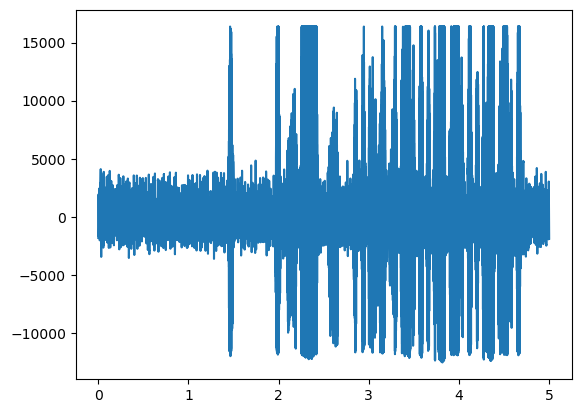

In [2]:
# Load in the wav file
fs, audio = wavfile.read('2023_03_31_7_03_30.wav')
t_song = np.arange(0, len(audio)/fs, 1/fs)
 
# Display the first 10 seconds of the wav file
disp_t = 5
plt.plot(t_song[:fs*disp_t], audio[:fs*disp_t])

Get spectrogram and mel-transformed spectrograms of signal using aligned audio

In [3]:
# load in data from csv file
notes = pd.read_csv('2023_03_31_7_03_30_annotated.txt', sep='\t', 
                                                        header=None, 
                                                        names=['start', 'end', 'note'])

# create a new column with the audio data
notes['audio'] = notes.apply(lambda x: audio[int(x['start']*fs):int(x['end']*fs)], axis=1)

# zero pad the audio data to make them all the same length
max_len = max(notes['audio'].apply(len))
notes['audio'] = notes['audio'].apply(lambda x: np.pad(x, (0, max_len-len(x)), 'constant'))

In [4]:
# Use librosa to get stft for each note
import librosa
n_fft = 1323
hop_length = 165

notes['stft'] = notes['audio'].apply(lambda x: 
                                     librosa.amplitude_to_db(
                                     librosa.stft(x.astype(float), 
                                                  n_fft=n_fft, 
                                                  hop_length=hop_length)))

C:\Users\nriveira\AppData\Local\Temp\ipykernel_23820\501710557.py:7: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.amplitude_to_db(


In [5]:
# Also get mel spectrogram transformation from stft
notes['mel_spec'] = notes['stft'].apply(lambda x: 
                                        librosa.feature.melspectrogram(S=x,
                                                                       sr=fs, 
                                                                       n_fft=n_fft, 
                                                                       hop_length=hop_length))

Show spectrogram and Mel-transformed spectrogram

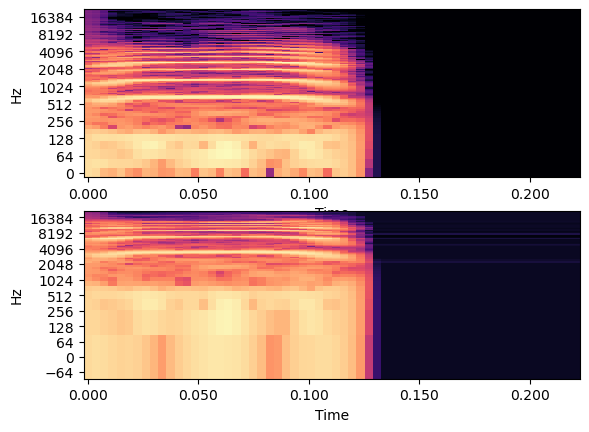

In [6]:
num = 4
plt.subplot(2,1,1)
librosa.display.specshow(librosa.amplitude_to_db(notes['stft'][num], 
                                         ref=np.max),
                                         sr=fs, 
                                         hop_length=hop_length, 
                                         x_axis='time', 
                                         y_axis='log')

plt.subplot(2,1,2)
librosa.display.specshow(librosa.amplitude_to_db(notes['mel_spec'][num], 
                                         ref=np.max),
                                         sr=fs, 
                                         hop_length=hop_length, 
                                         x_axis='time', 
                                         y_axis='log')

UMAP Embedding

In [7]:
import umap
from sklearn.cluster import HDBSCAN

colors = notes['note'].astype('category').cat.codes
stft_data = np.array(notes['stft'].tolist())
mel_data = np.array(notes['mel_spec'].tolist())

reducer = umap.UMAP(n_neighbors=15, random_state=42)
reducer_mel = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(stft_data.reshape(stft_data.shape[0], -1))
embedding_mel = reducer_mel.fit_transform(mel_data.reshape(mel_data.shape[0], -1))
hdbscan = HDBSCAN(min_cluster_size=15).fit(embedding)
hdbscan_mel = HDBSCAN(min_cluster_size=15).fit(embedding_mel)

# map specific notes to numbers for plotting
plt.subplot(221)
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap='Spectral', s=5, alpha=0.5)
plt.title('UMAP projection')

# Use embedding to cluster the notes
plt.subplot(222)
plt.scatter(embedding[:, 0], embedding[:, 1], c=hdbscan.labels_, cmap='Spectral', s=5, alpha=0.5)
plt.title('Predicted clusters')

# Use embedding to cluster the notes
plt.subplot(223)
plt.scatter(embedding_mel[:, 0], embedding_mel[:, 1], c=colors, cmap='Spectral', s=5, alpha=0.5)
plt.title('Mel Spectrogram')

# Use embedding to cluster the notes
plt.subplot(224)
plt.scatter(embedding_mel[:, 0], embedding_mel[:, 1], c=hdbscan_mel.labels_, cmap='Spectral', s=5, alpha=0.5)
plt.title('Mel Spectrogram')

plt.tight_layout()

c:\Users\nriveira\AppData\Local\anaconda3\envs\librosa\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\nriveira\AppData\Local\anaconda3\envs\librosa\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\nriveira\AppData\Local\anaconda3\envs\librosa\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


T-SNE Embedding

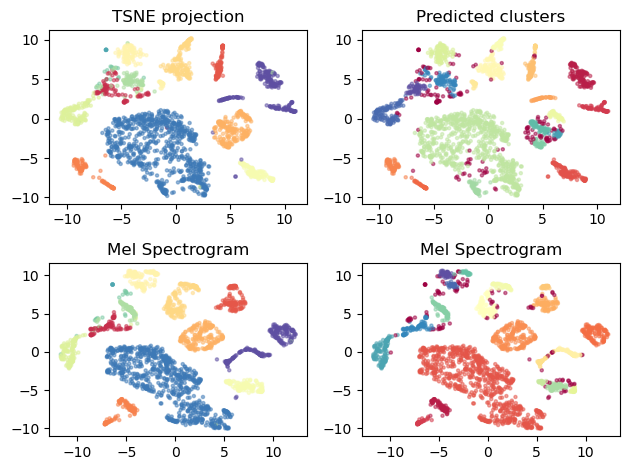

In [97]:
# Try clustering the data using TSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_mel = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(stft_data.reshape(stft_data.shape[0], -1))
tsne_results_mel = tsne_mel.fit_transform(mel_data.reshape(mel_data.shape[0], -1))
hdbscan = HDBSCAN(min_cluster_size=15).fit(tsne_results)
hdbscan_mel = HDBSCAN(min_cluster_size=15).fit(tsne_results_mel)

plt.subplot(221)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, cmap='Spectral', s=5, alpha=0.5)
plt.title('TSNE projection')

plt.subplot(222)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=hdbscan.labels_, cmap='Spectral', s=5, alpha=0.5)
plt.title('Predicted clusters')

plt.subplot(223)
plt.scatter(tsne_results_mel[:, 0], tsne_results_mel[:, 1], c=colors, cmap='Spectral', s=5, alpha=0.5)
plt.title('Mel Spectrogram')

plt.subplot(224)
plt.scatter(tsne_results_mel[:, 0], tsne_results_mel[:, 1], c=hdbscan_mel.labels_, cmap='Spectral', s=5, alpha=0.5)
plt.title('Mel Spectrogram')

plt.tight_layout()

DBSCAN Clustering

Text(0.5, 1.0, 'Predicted Clusters')

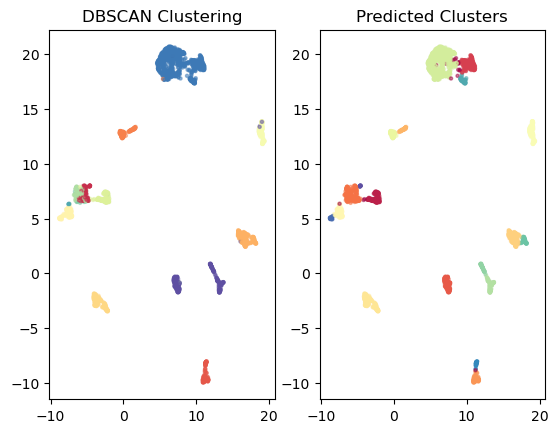

In [88]:
# Use HDBSCAN to cluster the data
from sklearn.cluster import DBSCAN

clusterer = DBSCAN(eps=0.3, min_samples=10)
cluster_labels = clusterer.fit_predict(embedding)

# Plot the clusters
plt.subplot(121)
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap='Spectral', s=5, alpha=0.5)
plt.title('DBSCAN Clustering')

# Plot the clusters
plt.subplot(122)
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='Spectral', s=5, alpha=0.5)
plt.title('Predicted Clusters')


In [99]:
colors

0        7
1        7
2       11
3       12
4       11
        ..
2219    11
2220    11
2221    11
2222    11
2223    11
Length: 2224, dtype: int8